# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


# Project Business Objectives

The primary goal of this project is to develop a model that accurately predicts the **tax-assessed value (taxvaluedollarcnt)** of properties. This model will enable Zillow to deliver significant business value in the following ways:

## 1. Enhanced Customer Experience
By providing home buyers and sellers with **reliable information** about expected tax burdens, Zillow can:
- Increase the value of its website.
- Improve **user satisfaction** and foster greater loyalty.

## 2. New Business Opportunities
An accurate tax-assessed value prediction model can serve as a **valuable data product** for B2B customers, including:
- **Financial institutions** for loan underwriting.
- **Insurance companies** for premium calculations.
- **Real estate investors** for asset valuation.

## 3. Internal Decision-Making Support
Zillow’s real estate investment division or market analysis team can leverage this model to:
- Identify **regions or properties** with high investment potential.
- Support **strategic market analysis** and investment decisions.

**1.2:**  How will your solution be used?


# Integration of the Regression Model into Zillow's Services

The developed regression model will be integrated into Zillow’s services in the following ways to enhance functionality and create value:

## 1. Website/App Feature Enhancement
When users view a property listing on Zillow, the model will:
- Display the **estimated tax-assessed value** and **annual tax burden** alongside the current **Zestimate** (Zillow’s estimated home value).
- Help users better understand the **total cost of ownership** for a home purchase.

## 2. Internal Analytics Dashboard
Zillow’s marketing and strategy teams will leverage the model through an **interactive dashboard** to:
- Visualize **regional property value trends**.
- Analyze the impact of specific amenities (e.g., pools, garages) on property prices.
- Inform **marketing campaign strategies** based on data-driven insights.

## 3. API Service
The model will be offered as a **paid API** for external developers and partners (e.g., banks, mortgage companies) to:
- Integrate Zillow’s predictive capabilities into their own services.
- Enable **customized applications** for property valuation and financial planning.

**1.3:**  How should success (or failure) be measured?


# Measuring Project Success

The success of the project will be evaluated across two dimensions: **technical metrics** and **business metrics**.

## Technical Success Metrics

- **RMSE (Root Mean Squared Error)**: Measures the average error between the model’s predicted tax-assessed values and actual values. A lower RMSE indicates higher model accuracy, serving as a key success indicator.
- **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the data. A value closer to 1 reflects stronger explanatory power.

## Business Success Metrics

- **User Engagement**: Tracks increases in user time spent on the website, page views, and click-through rates for the tax prediction feature after its implementation.
- **Customer Satisfaction Survey**: Evaluates the direct impact of the new feature through user satisfaction scores and feedback.
- **Revenue Growth**: Measures direct revenue generated from API services or data product sales to assess the project’s financial success.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [3]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [5]:
df.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

### ## Detailed Guide to Zillow Dataset Features

Based on the factors that determine property value, the features are grouped into several major categories.

### I. Core Physical Characteristics (Attributes of the Building Itself)
This is the most basic information about the building's size, structure, and quality. It forms the foundation of price prediction.

* `calculatedfinishedsquarefeet` (Total finished living area), `finishedsquarefeet12` (Finished living area)
    * **Role and Importance:** **One of the most important features.** It represents the effective size of the building and has a very high positive correlation with price. `finishedsquarefeet12` is likely to be nearly identical information.
    * **Handling Tips:** If the two features are similar, you can use one as the main feature (the one with fewer missing values and more consistent data) or use them to impute each other's missing values. Since the distribution is highly skewed, applying a **log transform** can improve model performance.

* `bedroomcnt` (Number of bedrooms), `bathroomcnt` (Number of bathrooms), `roomcnt` (Total number of rooms)
    * **Role and Importance:** Key indicators of a home's structure and size. They are directly related to the convenience for the residents and have a large impact on price.
    * **Handling Tips:** `roomcnt` might be similar to the sum of `bedroomcnt` and `bathroomcnt`. High correlation between features can cause multicollinearity issues, so consider removing one or creating a new feature like 'area per room'.

* `yearbuilt` (Year built)
    * **Role and Importance:** Represents the age of the building. Generally, newer buildings have higher prices, but in some areas, vintage styles are preferred. It can also be converted into an 'age' feature (`current_year - yearbuilt`).
    * **Handling Tips:** It has relatively few missing values and can be used as is, or missing values can be imputed with the average year of nearby houses.

* `buildingqualitytypeid` (Building quality type ID)
    * **Role and Importance:** Very important information representing the overall construction quality of the building. However, it has a lot of missing values, making it tricky to use.
    * **Handling Tips:** It could be dropped due to too many missing values, but advanced techniques could be considered, such as building a separate model to predict this value or imputing it based on other features (like age and price range).

* `numberofstories` (Number of stories), `storytypeid` (Story type ID)
    * **Role and Importance:** Distinguishes between single-story and multi-story homes.
    * **Handling Tips:** Has many missing values. One might assume '1' is the default and fill NaNs, or try to infer it from other information.

### II. Amenities and Additional Features
These are facilities that add value beyond the basic structure.

* `poolcnt` (Number of pools), `poolsizesum` (Sum of pool sizes), `hashottuborspa` (Has hot tub or spa), etc.
    * **Role and Importance:** A representative luxury amenity that positively affects the price if present.
    * **Handling Tips:** **Missing values (`NaN`) most likely mean 'none' (0)**, so filling with `fillna(0)` is the best approach. Consolidating multiple pool-related features into a single binary feature like `has_pool` (0 or 1) can make it easier for the model to understand.

* `garagecarcnt` (Number of cars in garage), `garagetotalsqft` (Total garage square feet)
    * **Role and Importance:** Parking space is an important value factor, especially in urban areas.
    * **Handling Tips:** Similar to `poolcnt`, **missing values should be interpreted as 'no garage' (0)** and handled with `fillna(0)`.

* `fireplacecnt` (Number of fireplaces), `fireplaceflag` (Fireplace flag)
    * **Role and Importance:** An amenity favored in certain climates or cultures.
    * **Handling Tips:** Again, **a missing value is considered 'none' (0)**.

* `airconditioningtypeid` (Air conditioning type ID), `heatingorsystemtypeid` (Heating or system type ID)
    * **Role and Importance:** Essential systems; the type (e.g., central air) can affect value. Should be treated as categorical data.
    * **Handling Tips:** Missing values can be filled with an 'Unknown' category or the most frequent value (mode).

### III. Location Characteristics
The most important factor in real estate: 'location'.

* `latitude`, `longitude`
    * **Role and Importance:** **The most precise and powerful location information.** These coordinates implicitly contain information about the neighborhood, school district, transportation, noise levels, and all other local characteristics.
    * **Handling Tips:** These two features are critical for the model to learn spatial patterns and should be used as is. If there are missing values, it's best to drop those samples.

* `regionidcity`, `regionidcounty`, `regionidneighborhood`, `regionidzip`
    * **Role and Importance:** Categorical location information for city, county, neighborhood, and ZIP code. `regionidneighborhood` and `regionidzip` are often very closely related to house prices.
    * **Handling Tips:** As categorical data, they need to be transformed using techniques like one-hot encoding. However, if there are too many unique values, the dimensionality can explode, so techniques like grouping rare regions into an 'Other' category may be necessary.

### IV. Land and Zoning Characteristics
Information about the land the building sits on and its legal regulations.

* `lotsizesquarefeet` (Lot size in square feet)
    * **Role and Importance:** The size of the land excluding the building. It's important as it relates to yard size and potential for extensions.
    * **Handling Tips:** Like `calculatedfinishedsquarefeet`, the distribution is highly skewed, so a **log transform** is effective.

* `propertylandusetypeid` (Property land use type ID)
    * **Role and Importance:** **A very important differentiator.** It tells you if the land is for a single-family home, an apartment, a commercial building, etc. Filtering the data to analyze only 'single-family homes', for example, can improve model accuracy.

* `propertyzoningdesc` (Property zoning description)
    * **Role and Importance:** A more detailed legal description of land use. It may contain useful information, but as text data, it is very difficult to clean and use.
    * **Handling Tips:** It could be excluded in the initial analysis and revisited later with Natural Language Processing (NLP) techniques.

### V. Tax and Assessment Characteristics
Information about the official valuation and financial status.

* **`taxvaluedollarcnt`** (Total tax assessed value)
    * **Role and Importance:** **This is the prediction target of the project.**
    * **Handling Tips:** Rows with missing values in this column cannot be used for training as the ground truth is unknown. They must be removed.

* `taxdelinquencyflag` (Tax delinquency flag), `taxdelinquencyyear` (Tax delinquency year)
    * **Role and Importance:** Information that can hint at the owner's financial distress. It may imply that the property is a distressed asset or has been poorly maintained.
    * **Handling Tips:** A missing value likely means 'no delinquency'. A binary feature like `has_delinquency` could be created.

### VI. ID and Other/Redundant Features
Information used for data identification or cleaning rather than direct prediction.

* `parcelid`
    * **Role and Importance:** A unique ID for each property. It's not used for model training but is necessary for tracking and managing the data.
    * **Handling Tips:** Remove it before the modeling stage.

* `fips`, `censustractandblock`, `rawcensustractandblock`
    * **Role and Importance:** FIPS is a county code, and the others are census area IDs. They can be useful for joining with external demographic data (e.g., income levels, population density).
    * **Handling Tips:** If not joining with external data, they may be redundant with `regionid` features and could be considered for removal.

* `finishedfloor1squarefeet`, `finishedsquarefeet6`, `finishedsquarefeet13`, `finishedsquarefeet15`, `finishedsquarefeet50`
    * **Role and Importance:** Represent the area of specific parts of the house, like the first floor or base area.
    * **Handling Tips:** Most of these have a very high number of missing values, and since `calculatedfinishedsquarefeet` is a more comprehensive measure, these features can likely be safely dropped.

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

In [6]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols_df = pd.DataFrame(categorical_cols, columns=['Categorical Features'])

print(categorical_cols_df)

        Categorical Features
0             hashottuborspa
1  propertycountylandusecode
2         propertyzoningdesc
3              fireplaceflag
4         taxdelinquencyflag


Based on an analysis of the data, the features can be divided into two types of categorical variables based on their data type and meaning.

#### 1. Explicit Categorical Features (Object Dtype)
These are features whose data type is `object` (string), explicitly indicating they represent categories.

* `hashottuborspa`
* `propertycountylandusecode`
* `propertyzoningdesc`
* `fireplaceflag`
* `taxdelinquencyflag`

#### 2. Numerical Features to be Treated as Categorical
These features have a numerical data type, but their values represent specific codes, grades, or types rather than a continuous quantity. They must be handled as categorical variables during modeling.

* **Key Examples:**
    * `airconditioningtypeid` (Air conditioning type code)
    * `buildingqualitytypeid` (Building quality grade)
    * `heatingorsystemtypeid` (Heating system type code)
    * `propertylandusetypeid` (Property land use type code)
    * `fips` (Regional code)
    * `numberofstories` (Number of stories)

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

Yes, based on an initial exploration of the data, several types of features appear to be useless for the business purpose of predicting property value or are technically unsuitable for modeling. They can be considered for removal for the following reasons:

#### 1. Identifier (ID) Features
* **Description:** These features serve only to uniquely identify each property and do not contain intrinsic characteristics that would influence its value. Therefore, they lack predictive power for a model.
* **Examples:** `parcelid`, `rawcensustractandblock`, `censustractandblock`

#### 2. Redundant Features
* **Description:** When the dataset contains a primary feature that more accurately or comprehensively captures a piece of information, other similar or subordinate features can be considered redundant. Keeping them can unnecessarily complicate the model.
* **Example:** If `calculatedfinishedsquarefeet` is the most reliable measure of a property's total area, other specific area-related features like `finishedsquarefeet12` or `finishedsquarefeet15` could be considered for removal.

#### 3. Zero-Variance Features
* **Description:** Features that have only a single unique value across all observations offer no information for a model to learn from, as they do not explain any variation in the data.
* **Example:** `assessmentyear` (as all properties in the dataset were assessed in the same year).

#### 4. Features with Excessive Missing Values
* **Description:** Features where more than 95% of the data is missing are of little practical use. They contain almost no information, and attempting to impute such a large number of missing values statistically carries a high risk of distorting the data.
* **Examples:** `buildingclasstypeid`, `finishedsquarefeet13`, `basementsqft`, `storytypeid` (which have over 99% missing values).

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

In [7]:
missing_values = df.isnull().sum()
total_rows = len(df)
missing_percentage = (missing_values / total_rows) * 100

missing_info = pd.DataFrame({
    'Total_Rows': total_rows,
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_percentage
})



In [8]:
missing_info.sort_values(by='Missing_Percentage', ascending=False)

,Total_Rows,Missing_Count,Missing_Percentage
buildingclasstypeid,77613,77598,99.980673
finishedsquarefeet13,77613,77571,99.945885
storytypeid,77613,77563,99.935578
basementsqft,77613,77563,99.935578
yardbuildingsqft26,77613,77543,99.909809
fireplaceflag,77613,77441,99.778388
architecturalstyletypeid,77613,77406,99.733292
typeconstructiontypeid,77613,77390,99.712677
finishedsquarefeet6,77613,77227,99.502661
pooltypeid10,77613,77148,99.400874


Yes, there are features that appear useless due to a high percentage of missing values. However, it is crucial to differentiate them based on the **reason** for the missing data. Based on this criterion, the features can be divided into two groups:

#### 1. Features to Consider for Removal (Useless due to Lack of Information)
For these features, a missing value likely means the data is truly unknown, and the percentage of missingness is so high (generally >95%) that they provide almost no reliable information. Imputing these values would carry a high risk of data distortion.

* **Examples:**
    * `buildingclasstypeid`: **99.98%** missing
    * `basementsqft`: **99.94%** missing
    * `storytypeid`: **99.94%** missing
    * `architecturalstyletypeid`: **99.73%** missing

#### 2. Useful Features to Keep (Where Missing Means 'Zero')
For this group of features, a high percentage of missing values simply indicates that most properties do not have that particular attribute. In these cases, the "missing" data is actually meaningful information ('0') and should be preserved. Therefore, these features should be **kept, and their missing values should be imputed with 0.**

* **Examples:**
    * `fireplacecnt`: **89.3%** missing, which implies these properties do not have a fireplace.
    * `poolcnt`: **79.2%** missing, which implies these properties do not have a pool.
    * `garagecarcnt`: **67.1%** missing, which implies these properties do not have a garage.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Yes, based on the number of unique values, the following two types of features appear to be useless for modeling purposes.

#### 1. Identifier (ID) Features

* **Description:** Features with a very large number of unique values, approaching the total number of records, typically serve as identifiers. They do not contain generalizable information and are therefore not suitable for a predictive model.
* **Example:** `parcelid`

#### 2. Zero-Variance Features

* **Description:** This refers to features that have only one unique value across all non-missing records. Since the value is constant, it has no variance and thus provides no information for a model to learn from.
* **Example:** `assessmentyear`

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

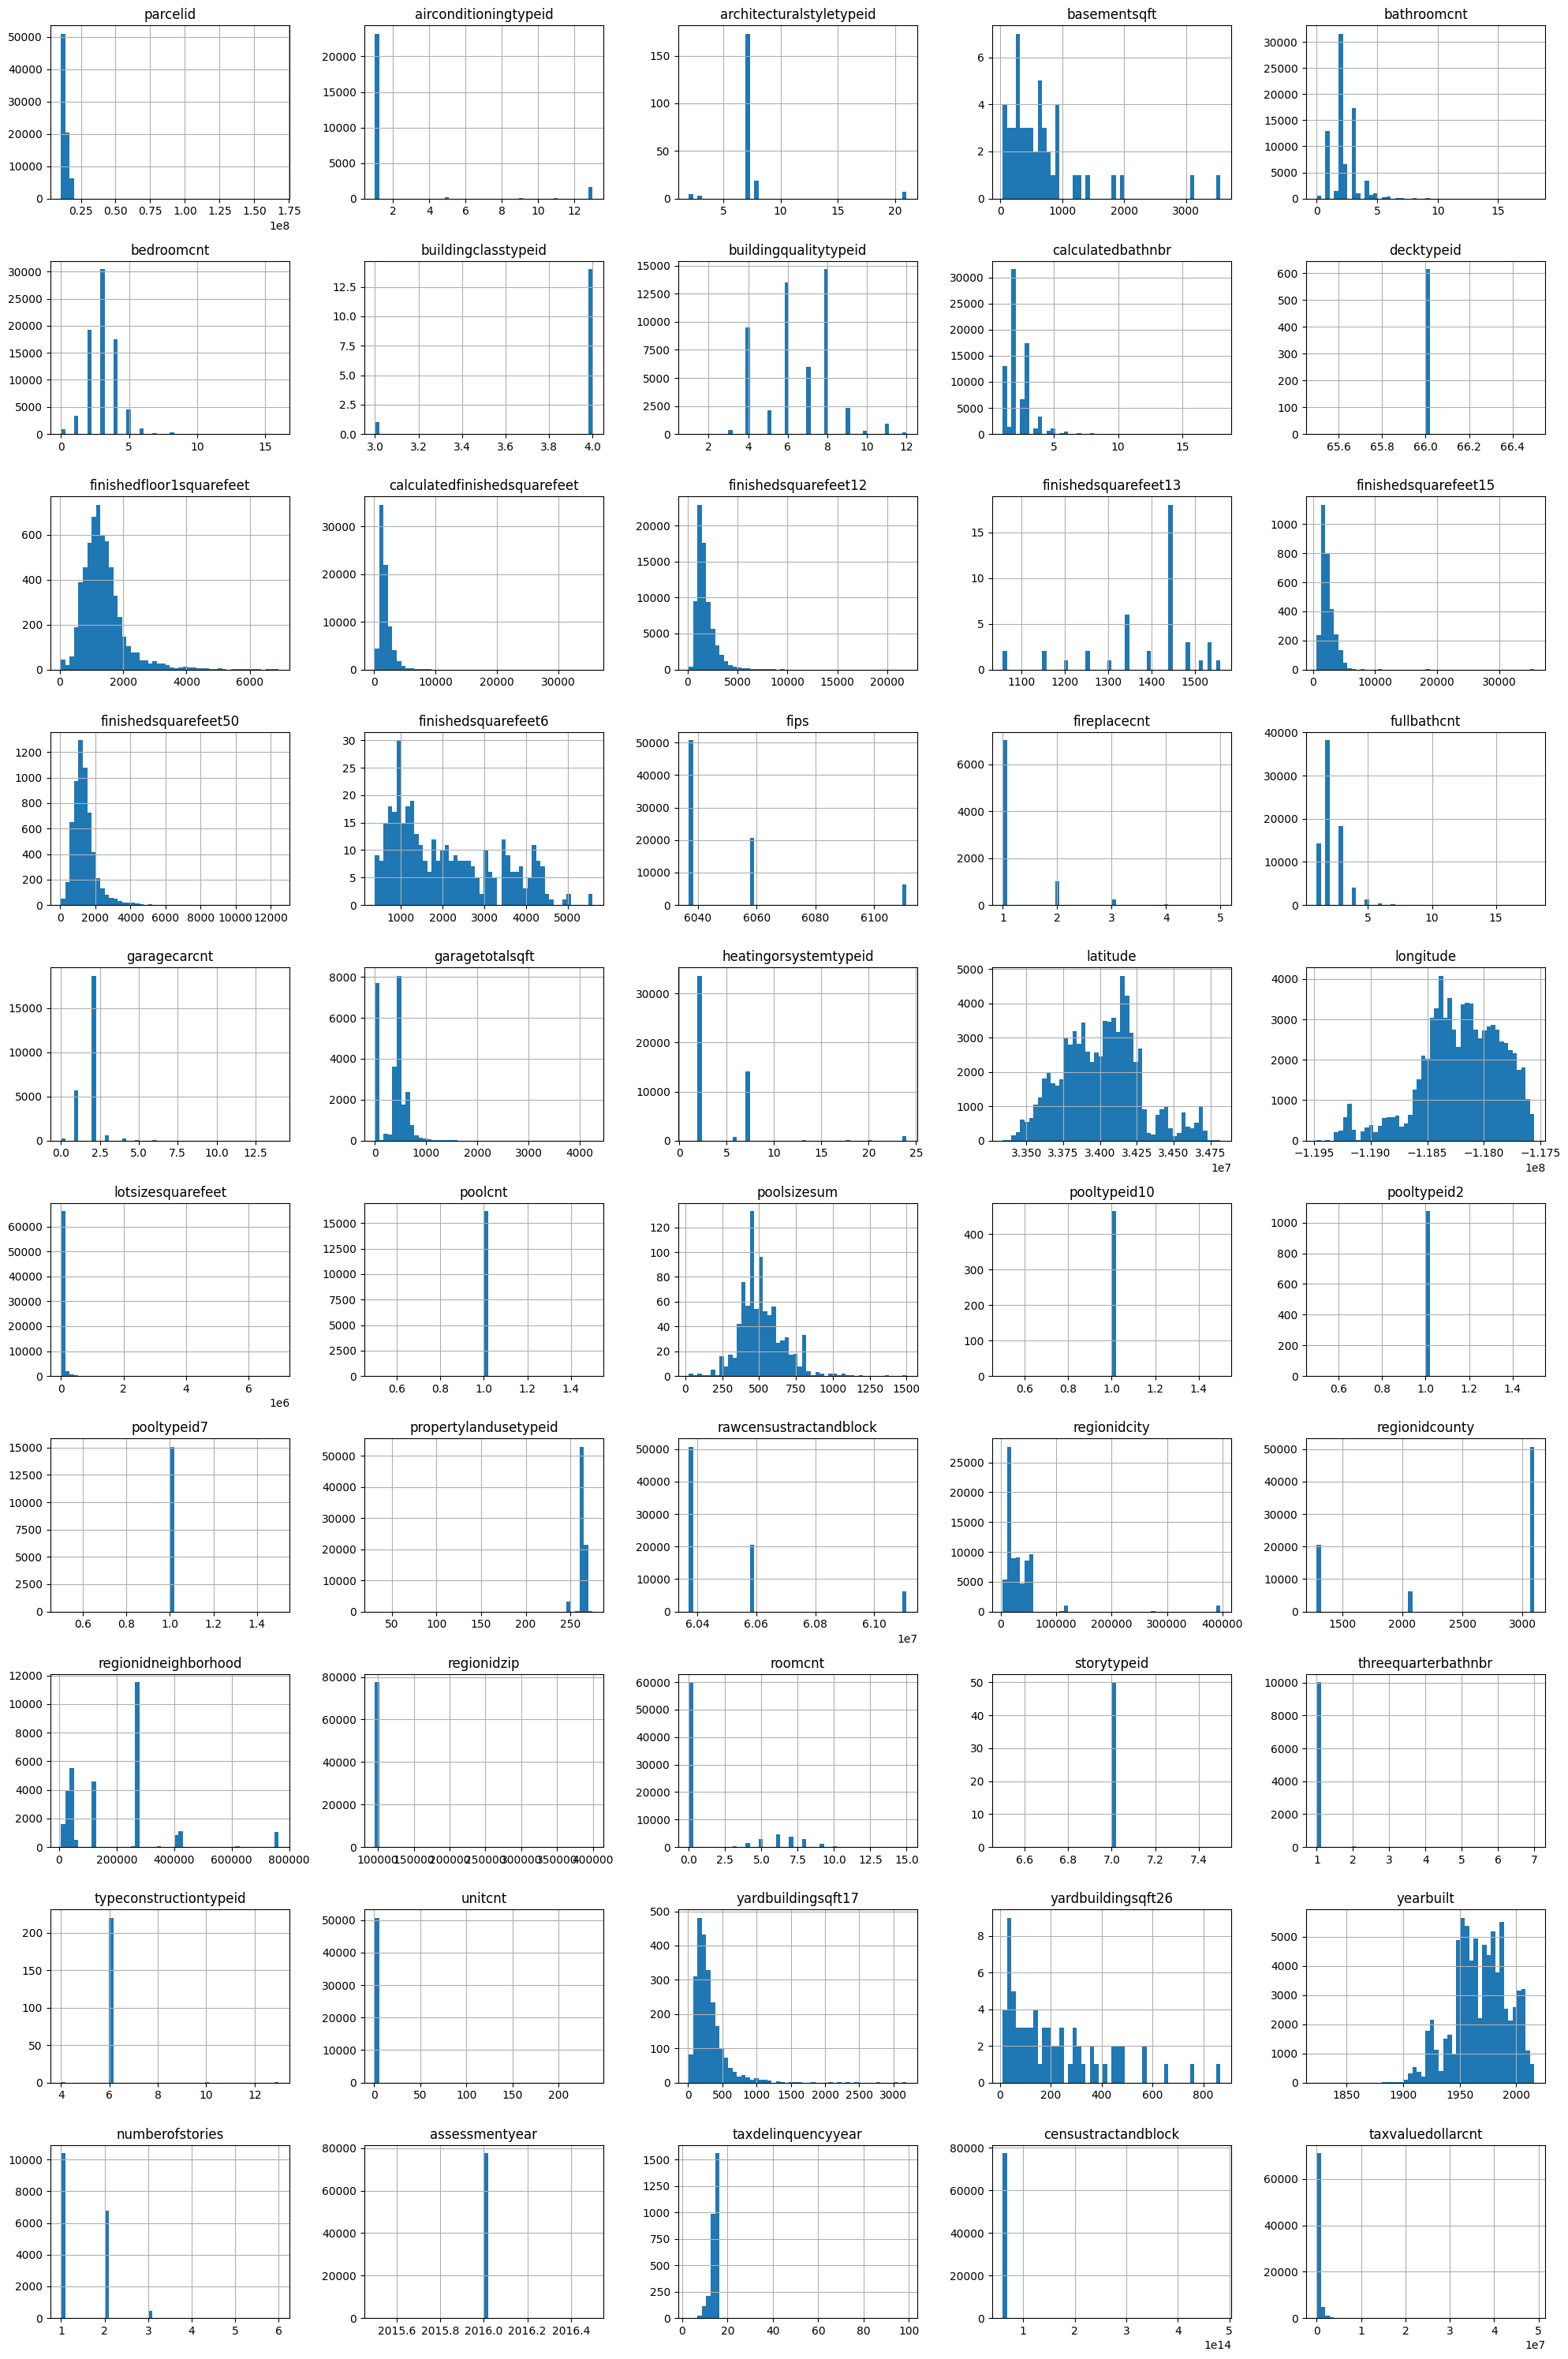

In [9]:
df.hist(bins=50, figsize=(20,30),layout=(-1, 5))
plt.tight_layout()
plt.show()

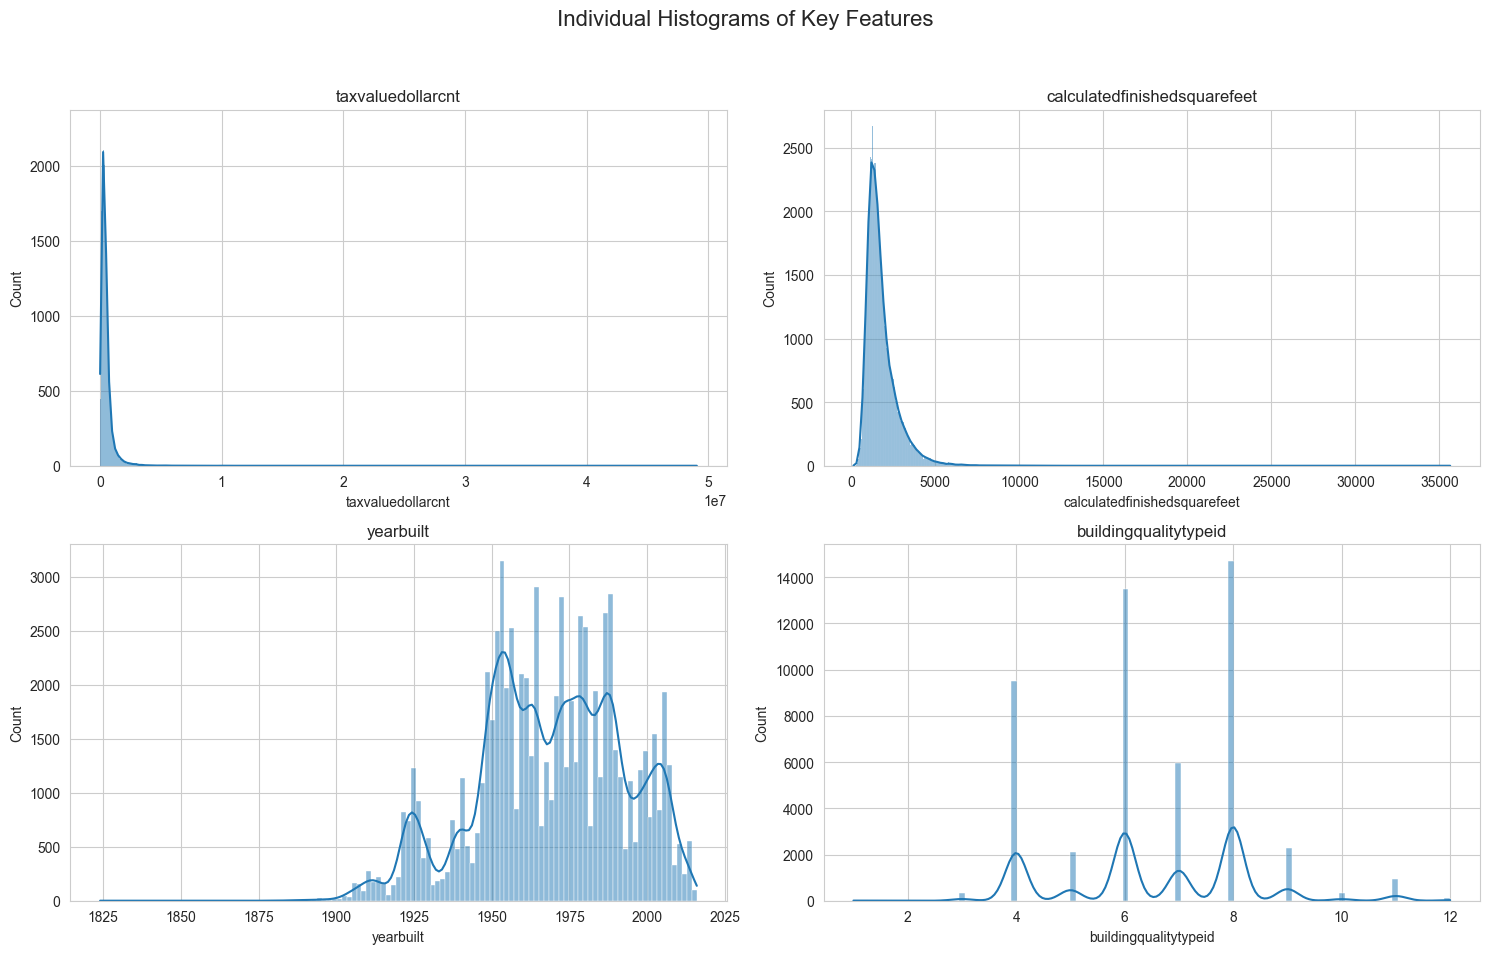

In [10]:
features_to_plot = ['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'buildingqualitytypeid']
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Individual Histograms of Key Features', fontsize=16)
sns.histplot(data=df, x=features_to_plot[0], kde=True, ax=axes[0, 0]).set_title(features_to_plot[0])
sns.histplot(data=df, x=features_to_plot[1], kde=True, ax=axes[0, 1]).set_title(features_to_plot[1])
sns.histplot(data=df, x=features_to_plot[2], kde=True, ax=axes[1, 0]).set_title(features_to_plot[2])
sns.histplot(data=df, x=features_to_plot[3], kde=True, ax=axes[1, 1]).set_title(features_to_plot[3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

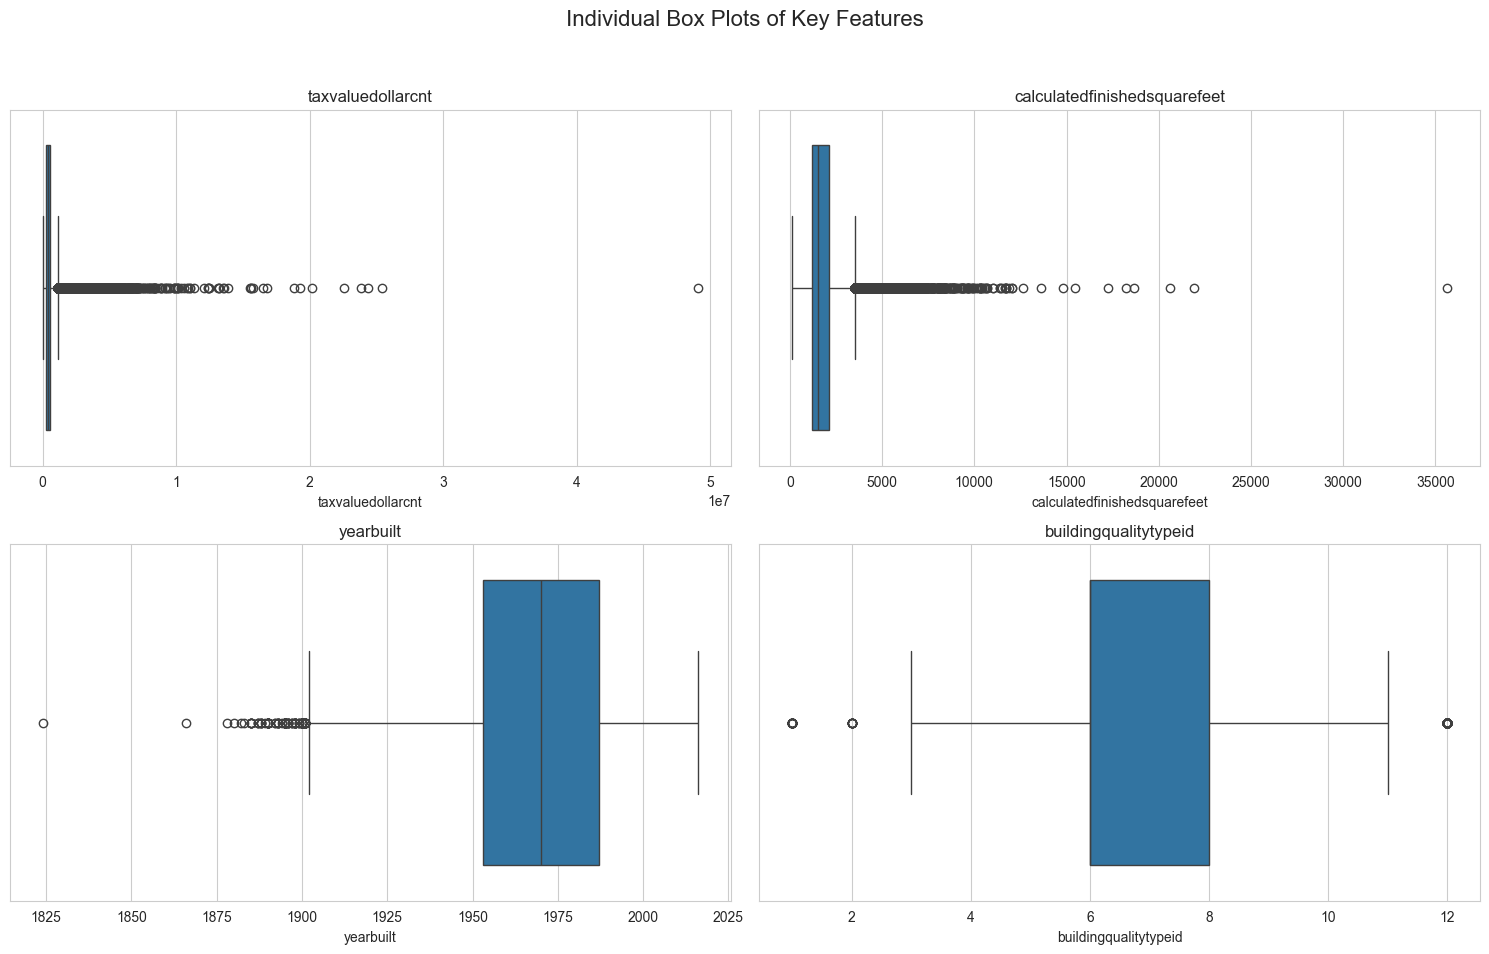

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Individual Box Plots of Key Features', fontsize=16)
sns.boxplot(data=df, x=features_to_plot[0], ax=axes[0, 0]).set_title(features_to_plot[0])
sns.boxplot(data=df, x=features_to_plot[1], ax=axes[0, 1]).set_title(features_to_plot[1])
sns.boxplot(data=df, x=features_to_plot[2], ax=axes[1, 0]).set_title(features_to_plot[2])
sns.boxplot(data=df, x=features_to_plot[3], ax=axes[1, 1]).set_title(features_to_plot[3])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?



Based on the individual histograms and box plots created for the target variable and three selected features, the following observations were made.

#### **1. `taxvaluedollarcnt` (Target Variable)**

* **Distribution & Problems:** The histogram reveals a classic right-skewed distribution, similar to a log-normal curve. This indicates that most properties are clustered at lower values, with a long tail of high-value properties. The box plot visually confirms this, clearly showing a significant number of outliers on the upper end. These outliers could disproportionately influence the training of linear models, suggesting that a log transformation might be a necessary preprocessing step.
* **Reason for Choice:** As the project's target variable, a thorough understanding of its distribution is fundamental to the entire modeling process.

#### **2. `calculatedfinishedsquarefeet` (Total Finished Area)**

* **Distribution & Problems:** The histogram for this feature closely mirrors the target variable's right-skewed distribution, which is intuitive as larger homes are typically rarer and more valuable. The box plot likewise highlights a large number of outliers, representing exceptionally large properties.
* **Reason for Choice:** This is one of the most important and intuitive predictors of property value. Its distributional similarity to the target variable strongly suggests a positive correlation and makes it a critical feature to analyze.

#### **3. `yearbuilt` (Year Built)**

* **Distribution & Problems:** The histogram for `yearbuilt` shows a unique multi-modal distribution, not a standard one. There is a prominent peak around the 1950s, likely corresponding to a post-war housing boom. The box plot does not show extreme outliers in the same manner as price or area, but the distribution's overall left-skewed, multi-modal shape suggests that its relationship with property value is likely non-linear.
* **Reason for Choice:** The unique distribution was chosen for its interesting narrative; it tells a story about the historical development of the region's housing stock.

#### **4. `buildingqualitytypeid` (Building Quality Grade)**

* **Distribution & Problems:** For this discrete, categorical feature, the histogram is more informative than the box plot. It shows an uneven distribution, with data concentrated in a few specific quality grades while others are rare. The most significant problem with this feature, identified earlier, is its high percentage of missing values.
* **Reason for Choice:** This feature was selected because, as a direct measure of construction quality, it is a potentially powerful predictor. Analyzing the distribution of the available data is a crucial first step in deciding on a viable imputation strategy.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [12]:
# Create a copy of the original DataFrame
df_clean = df.copy()

# Check the number of rows before dropping duplicates
print(f"Number of rows before dropping duplicates: {len(df_clean)}")

# METHOD 1 (RECOMMENDED): Remove 'inplace=True' and assign the new DataFrame to the variable
df_clean_drop = df_clean.drop_duplicates(subset='parcelid', keep='first')

# Check the number of rows after dropping duplicates
print(f"Number of rows after dropping duplicates: {len(df_clean_drop)}")


# Define the list of columns to remove based on analysis
cols_to_drop_logical = [
    # 1. Identifier Features
    'parcelid',
    'rawcensustractandblock',
    'censustractandblock',

    # 2. Redundant Area Features
    'finishedfloor1squarefeet',
    'finishedsquarefeet6',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',

    # 3. True Zero-Variance Features
    'assessmentyear',
    'decktypeid'
]

# Use the list above to remove the columns from the de-duplicated DataFrame
df_3a = df_clean_drop.drop(columns=cols_to_drop_logical)

Number of rows before dropping duplicates: 77613
Number of rows after dropping duplicates: 77414


In [13]:
df_clean.shape, df_3a.shape

((77613, 55), (77414, 44))

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


To improve model performance and ensure data integrity, redundant rows and unnecessary features were removed from the dataset based on the following logical criteria.

#### 1. Duplicate Records (Row Removal)
* **Rationale:** The `parcelid` should be a unique identifier for each property, but duplicate values were found in the dataset. This indicates that the same property was recorded multiple times. To ensure each property is represented only once and to prevent over-representation of certain properties, duplicate rows were removed based on `parcelid`, keeping only the first entry for each.

#### 2. Identifier (ID) Features (Column Removal)
* **Rationale:** Features like `rawcensustractandblock` serve as unique identifiers. They do not contain intrinsic characteristics that determine a home's value and therefore provide no predictive information to a model. The `parcelid` column itself was also dropped after being used to remove duplicate rows.
* **Features Removed:** `parcelid`, `rawcensustractandblock`, `censustractandblock`

#### 3. Redundant Features (Column Removal)
* **Rationale:** As `calculatedfinishedsquarefeet` (total finished area) is the most comprehensive measure, other subordinate and redundant area-related features were removed to simplify the model and avoid multicollinearity.
* **Features Removed:** `finishedfloor1squarefeet`, `finishedsquarefeet6`, `finishedsquarefeet12`, etc.

#### 4. Zero-Variance Features (Column Removal)
* **Rationale:** Features that have only a single unique value across all records, such as `assessmentyear`, have no variance and thus contribute no information to the model.
* **Features Removed:** `assessmentyear`, `decktypeid`

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [14]:
missing_values_3b = df_3a.isnull().sum()
total_rows_3b = len(df_3a)
missing_percentage_3b = (missing_values_3b / total_rows_3b) * 100

missing_info_3b = pd.DataFrame({
    'Total_Rows': total_rows_3b,
    'Missing_Count': missing_values_3b,
    'Missing_Percentage': missing_percentage_3b
})

In [15]:
missing_info_3b.sort_values(by='Missing_Percentage', ascending=False)

,Total_Rows,Missing_Count,Missing_Percentage
buildingclasstypeid,77414,77399,99.980624
basementsqft,77414,77364,99.935412
storytypeid,77414,77364,99.935412
yardbuildingsqft26,77414,77344,99.909577
fireplaceflag,77414,77242,99.777818
architecturalstyletypeid,77414,77208,99.733898
typeconstructiontypeid,77414,77192,99.713230
pooltypeid10,77414,76950,99.400625
poolsizesum,77414,76547,98.880048
pooltypeid2,77414,76340,98.612654


In [16]:
cols_to_drop_3b_candidates = missing_info_3b[missing_percentage > 95].index.tolist()

C:\Users\abcbb\AppData\Local\Temp\ipykernel_10300\3188927743.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cols_to_drop_3b_candidates = missing_info_3b[missing_percentage > 95].index.tolist()


In [17]:
cols_to_drop_3b_candidates

['architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'hashottuborspa',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'storytypeid',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear']

In [18]:
cols_to_drop_3b = [
    'architecturalstyletypeid',
    'basementsqft',
    'buildingclasstypeid',
    'storytypeid',
    'typeconstructiontypeid',
    'yardbuildingsqft17',
    'yardbuildingsqft26'
]

df_3b = df_3a.drop(columns=cols_to_drop_3b)

print(f"Columns removed in 3b: {cols_to_drop_3b}")
print(f"Shape after 3b: {df_3b.shape}")
print(df_3b.info())

Columns removed in 3b: ['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26']
Shape after 3b: (77414, 37)
<class 'pandas.core.frame.DataFrame'>
Index: 77414 entries, 0 to 77612
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         24953 non-null  float64
 1   bathroomcnt                   77381 non-null  float64
 2   bedroomcnt                    77381 non-null  float64
 3   buildingqualitytypeid         49672 non-null  float64
 4   calculatedbathnbr             76772 non-null  float64
 5   calculatedfinishedsquarefeet  77185 non-null  float64
 6   fips                          77381 non-null  float64
 7   fireplacecnt                  8276 non-null   float64
 8   fullbathcnt                   76772 non-null  float64
 9   garagecarcnt                  25474 no

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



To improve model stability and reliability, a process was undertaken to remove features with a high percentage of missing data. First, features with a missing value percentage of **95% or higher** were considered candidates for removal. However, not all features meeting this criterion were dropped. Useful features like `fireplaceflag` and `poolcnt`, where a missing value signifies 'the facility does not exist' (a value of 0), were intentionally excluded from this removal process to prevent information loss. Based on this standard, a final set of 7 features, including `architecturalstyletypeid` and `basementsqft`, were selected and removed, as they contained very little information and posed a high risk of data distortion if imputed.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [19]:
# Print the shape before dropping rows
print(f"Shape before dropping: {df_3b.shape}")

# Drop rows where 'taxvaluedollarcnt' is null
df_3c = df_3b.dropna(subset=['taxvaluedollarcnt'])

# Print the shape after dropping rows
print(f"Shape after dropping: {df_3c.shape}")

# Calculate the number of dropped rows
rows_dropped = df_3b.shape[0] - df_3c.shape[0]
print(f"\nTotal rows dropped: {rows_dropped}")

Shape before dropping: (77414, 37)
Shape after dropping: (77380, 37)

Total rows dropped: 34


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


In this step, a small number of samples (rows) were removed from the dataset. The sole criterion for removal was the presence of a null (`NaN`) value in the `taxvaluedollarcnt` column. This column is our **target variable**, the value we are trying to predict. In supervised machine learning, the model learns the relationship between the input features and the known target value. If the target value for a given sample is missing, that sample is unusable for training or evaluating the model. Therefore, these rows were removed to ensure the integrity of the dataset for the regression task.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [20]:
# Create a copy to avoid chained assignment issues from the start
df_3d = df_3c.copy()

print(f"Shape before imputation: {df_3d.shape}")
print(f"Total missing values before imputation: {df_3d.isnull().sum().sum()}")

# --- Step 1: Impute with 0 for features where NaN means 'none' or 'zero' ---
# The user wants to include roomcnt and bedroomcnt in this group.
cols_to_fill_zero = [
    'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
    'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10',
    'pooltypeid2', 'pooltypeid7', 'taxdelinquencyflag', 'taxdelinquencyyear',
    'fireplaceflag', 'roomcnt', 'bedroomcnt' # Added based on user feedback
]
existing_cols_zero = [col for col in cols_to_fill_zero if col in df_3d.columns]
for col in existing_cols_zero:
    if df_3d[col].dtype == 'object':
        df_3d[col] = (df_3d[col].notnull()).astype(int)
    else:
        # Assign the result back to the column to avoid warnings
        df_3d[col] = df_3d[col].fillna(0)


# --- Step 2: Impute remaining numerical features with the median ---
numerical_cols = df_3d.select_dtypes(include=np.number).columns.tolist()
# This list now automatically excludes roomcnt and bedroomcnt
numerical_cols_to_impute = [col for col in numerical_cols if col not in existing_cols_zero and df_3d[col].isnull().any()]

for col in numerical_cols_to_impute:
    median_val = df_3d[col].median()
    # Assign the result back to the column
    df_3d[col] = df_3d[col].fillna(median_val)


# --- Step 3: Impute remaining categorical features with the mode ---
categorical_cols = df_3d.select_dtypes(include='object').columns.tolist()
categorical_cols_to_impute = [col for col in categorical_cols if df_3d[col].isnull().any()]

for col in categorical_cols_to_impute:
    mode_val = df_3d[col].mode()[0]
    # Assign the result back to the column
    df_3d[col] = df_3d[col].fillna(mode_val)


# --- Final Check for Missing Values ---
remaining_nulls = df_3d.isnull().sum().sum()
print(f"\nTotal remaining missing values: {remaining_nulls}")

if remaining_nulls == 0:
    print("Successfully imputed all missing values.")
else:
    print("Warning: There are still missing values in the dataframe.")


Shape before imputation: (77380, 37)
Total missing values before imputation: 1175247

Total remaining missing values: 0
Successfully imputed all missing values.


In [21]:
df_3d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77380 entries, 0 to 77612
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         77380 non-null  float64
 1   bathroomcnt                   77380 non-null  float64
 2   bedroomcnt                    77380 non-null  float64
 3   buildingqualitytypeid         77380 non-null  float64
 4   calculatedbathnbr             77380 non-null  float64
 5   calculatedfinishedsquarefeet  77380 non-null  float64
 6   fips                          77380 non-null  float64
 7   fireplacecnt                  77380 non-null  float64
 8   fullbathcnt                   77380 non-null  float64
 9   garagecarcnt                  77380 non-null  float64
 10  garagetotalsqft               77380 non-null  float64
 11  hashottuborspa                77380 non-null  int32  
 12  heatingorsystemtypeid         77380 non-null  float64
 13  latitu

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


To handle all remaining missing values and create a complete dataset for modeling, a multi-step imputation strategy was employed that considered the data type and meaning of each feature. First, for features like `poolcnt` and `fireplacecnt`, where a missing value signifies the absence of that feature, a value of '0' was imputed to preserve this information. After consideration, `bedroomcnt` and `roomcnt` were also included in this method to account for studio-style properties. Next, for the remaining numerical features, the **median** was used for imputation; because our earlier analysis in Part 2 showed these features have skewed distributions, the median is a more robust measure of central tendency than the mean. Finally, for text-based categorical features like `propertyzoningdesc`, the standard practice of filling missing values with the **mode**, or most frequent category, was used. This multi-pronged approach ensures that all missing data is handled logically, maintaining the integrity of the dataset while preparing it for the next steps.

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [22]:
# Create a copy to work with
df_3e = df_3d.copy()

# Identify all columns that need to be one-hot encoded.
# This includes object types and numerical codes we've identified as categorical.
cols_to_encode = [
    # Object type columns
    'propertycountylandusecode',
    'propertyzoningdesc',
    # Numerical but categorical columns
    'airconditioningtypeid',
    'buildingqualitytypeid',
    'fips',
    'heatingorsystemtypeid',
    'numberofstories',
    'propertylandusetypeid',
    'regionidcity',
    'regionidcounty',
    'regionidneighborhood',
    'regionidzip'
]

# Ensure only columns that actually exist in the dataframe are included
# (Some might have been dropped in earlier steps if this code is run standalone)
existing_cols_to_encode = [col for col in cols_to_encode if col in df_3e.columns]


# Print the shape before encoding
print(f"Shape before one-hot encoding: {df_3e.shape}")
print(f"Number of columns to encode: {len(existing_cols_to_encode)}")

# Perform one-hot encoding using pd.get_dummies
df_3e = pd.get_dummies(df_3e, columns=existing_cols_to_encode, dtype='int')

# Print the shape after encoding
print(f"Shape after one-hot encoding: {df_3e.shape}")
print("\nCategorical feature encoding complete. The dataframe is now fully numerical.")

Shape before one-hot encoding: (77380, 37)
Number of columns to encode: 12
Shape after one-hot encoding: (77380, 3101)

Categorical feature encoding complete. The dataframe is now fully numerical.


In [23]:
df_3e

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,...,regionidzip_97318.0,regionidzip_97319.0,regionidzip_97323.0,regionidzip_97324.0,regionidzip_97328.0,regionidzip_97329.0,regionidzip_97330.0,regionidzip_97331.0,regionidzip_97344.0,regionidzip_399675.0
0,3.5,4.0,3.5,3100.0,0.0,3.0,2.0,633.0,0,33634931.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2.0,1.0,1465.0,1.0,1.0,1.0,0.0,0,34449266.0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,3.0,2.0,1243.0,0.0,2.0,2.0,440.0,0,33886168.0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,4.0,3.0,2376.0,0.0,3.0,0.0,0.0,0,34245180.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,3.0,3.0,1312.0,0.0,3.0,0.0,0.0,0,34185120.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,3.0,3.0,3.0,1741.0,0.0,3.0,0.0,0.0,0,34202400.0,...,0,0,0,0,0,0,0,0,0,0
77609,2.0,2.0,2.0,1286.0,0.0,2.0,0.0,0.0,0,34245368.0,...,0,0,0,0,0,0,0,0,0,0
77610,2.0,4.0,2.0,1612.0,1.0,2.0,2.0,560.0,0,34300140.0,...,0,0,0,0,0,0,0,0,0,0
77611,1.0,3.0,1.0,1032.0,0.0,1.0,0.0,0.0,0,34040895.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_3e.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77380 entries, 0 to 77612
Columns: 3101 entries, bathroomcnt to regionidzip_399675.0
dtypes: float64(22), int32(3079)
memory usage: 922.4 MB


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

In [25]:
corr_matrix = df_3e.corr()
target_corr = corr_matrix['taxvaluedollarcnt'].sort_values(ascending=False)

print(target_corr.head(11))

print(target_corr.tail(10))

taxvaluedollarcnt               1.000000
calculatedfinishedsquarefeet    0.578739
calculatedbathnbr               0.476898
fullbathcnt                     0.465349
bathroomcnt                     0.461620
bedroomcnt                      0.239077
buildingqualitytypeid_10.0      0.214316
regionidzip_96086.0             0.202966
buildingqualitytypeid_11.0      0.186156
buildingqualitytypeid_12.0      0.182821
propertyzoningdesc_BHR1*        0.169948
Name: taxvaluedollarcnt, dtype: float64
buildingqualitytypeid_5.0        -0.057027
propertycountylandusecode_34     -0.059939
buildingqualitytypeid_8.0        -0.063088
regionidcity_40227.0             -0.063372
regionidcity_5534.0              -0.075364
propertylandusetypeid_266.0      -0.091096
propertycountylandusecode_0100   -0.097765
latitude                         -0.098144
buildingqualitytypeid_4.0        -0.113756
heatingorsystemtypeid_7.0        -0.124002
Name: taxvaluedollarcnt, dtype: float64


In [26]:
# Create a copy for feature selection and f_regression
df_clean = df_3e.copy()

X = df_clean.drop(columns=['taxvaluedollarcnt'])
y = df_clean['taxvaluedollarcnt']

f_scores, p_values = f_regression(X, y)

# Create a DataFrame for better readability
f_stat_results = pd.DataFrame({'feature': X.columns, 'F_score': f_scores, 'p_value': p_values})
f_stat_results.sort_values(by='F_score', ascending=False, inplace=True)

print(f_stat_results.head(20))

                             feature       F_score  p_value
3       calculatedfinishedsquarefeet  38969.170579      0.0
2                  calculatedbathnbr  22778.785048      0.0
5                        fullbathcnt  21387.694078      0.0
0                        bathroomcnt  20953.785576      0.0
1                         bedroomcnt   4690.877819      0.0
2020      buildingqualitytypeid_10.0   3725.177058      0.0
2774             regionidzip_96086.0   3324.571711      0.0
2021      buildingqualitytypeid_11.0   2777.708884      0.0
2022      buildingqualitytypeid_12.0   2675.690049      0.0
239         propertyzoningdesc_BHR1*   2301.333751      0.0
25    propertycountylandusecode_0101   2257.970571      0.0
2794             regionidzip_96116.0   2214.430618      0.0
2072            regionidcity_12520.0   2212.564366      0.0
12                           poolcnt   2204.160806      0.0
2019       buildingqualitytypeid_9.0   1754.598440      0.0
706        propertyzoningdesc_LARE20   1

C:\Users\abcbb\AppData\Local\Temp\ipykernel_10300\1559889806.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F_score', y='feature', data=f_stat_results.head(20), palette='viridis')



A plot of the top 20 F-scores has been saved as 'f_scores_plot.png'


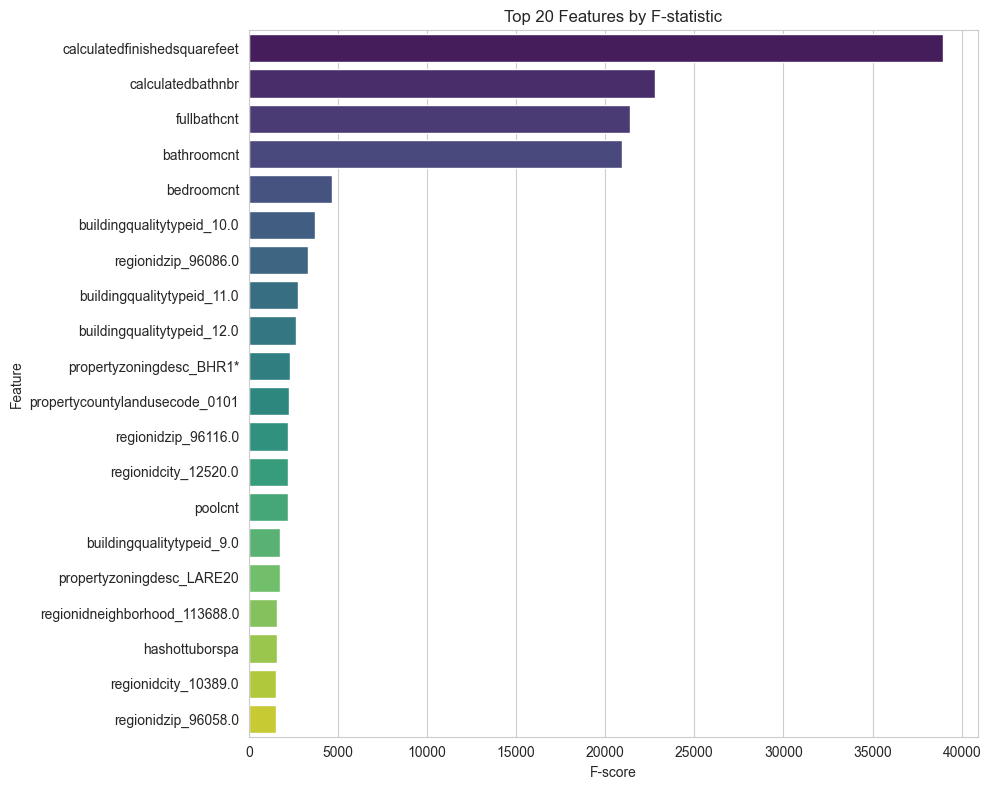

In [27]:
# Visualize the F-scores
plt.figure(figsize=(10, 8))
sns.barplot(x='F_score', y='feature', data=f_stat_results.head(20), palette='viridis')
plt.title('Top 20 Features by F-statistic')
plt.xlabel('F-score')
plt.ylabel('Feature')
plt.tight_layout()
print("\nA plot of the top 20 F-scores has been saved as 'f_scores_plot.png'")

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



An analysis of the relationships between features and the target variable (`taxvaluedollarcnt`), using both a correlation matrix and the F-statistic, yielded highly consistent and clear conclusions. Both analytical methods confirmed that **`calculatedfinishedsquarefeet` (total area) is the single most powerful predictor** of property value. Following that, features representing the physical size and structure of the home, such as `bathroomcnt` (bathroom count) and `bedroomcnt` (bedroom count), ranked among the most important predictors.

Interestingly, both methods also ranked specific one-hot encoded categorical features highly, such as those for `buildingqualitytypeid`, `regionidzip` (ZIP code), and `propertyzoningdesc` (zoning). This statistically supports the fact that in addition to a property's physical characteristics, its **quality and location have a significant impact on its value**. The F-statistic results largely reaffirmed the feature importance rankings from the correlation analysis, which gives us strong confidence that the key features we have identified are statistically significant and reliable.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

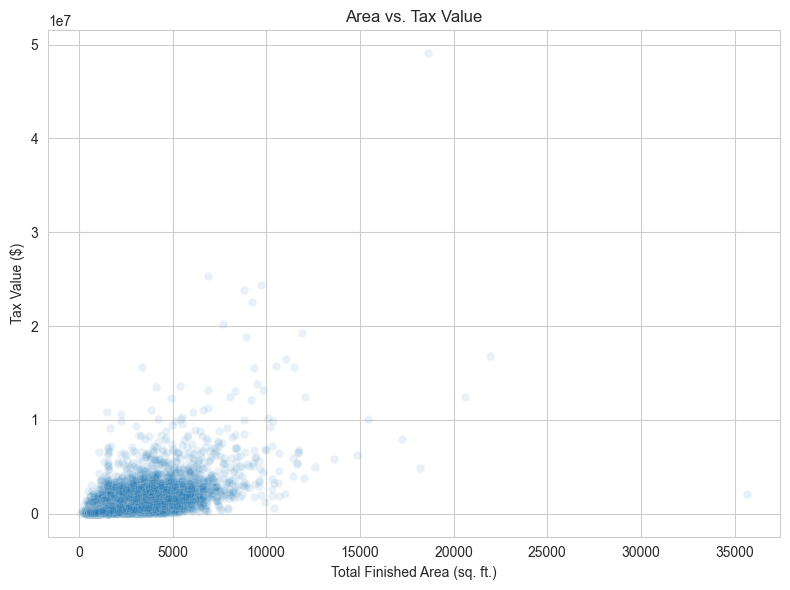

In [28]:
df_4b = df_3d.copy()

# Create a single figure and axis for one plot
plt.figure(figsize=(8, 6))

# Plot 1: Scatter plot of Area vs. Value
sns.scatterplot(
    x='calculatedfinishedsquarefeet',
    y='taxvaluedollarcnt',
    data=df_4b,
    alpha=0.1 # Use transparency to see point density
)

# Set titles and labels on the main plot
plt.title('Area vs. Tax Value')
plt.xlabel('Total Finished Area (sq. ft.)')
plt.ylabel('Tax Value ($)')

plt.tight_layout()

Text(0, 0.5, 'Tax Value ($)')

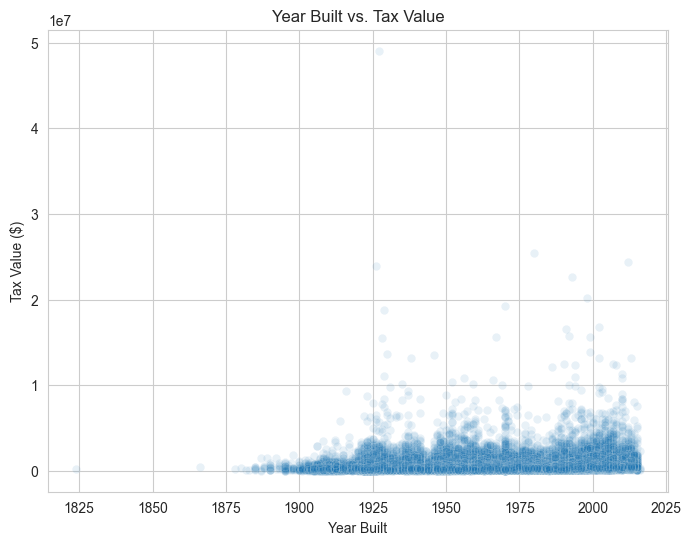

In [29]:
# Create a single figure and axis for one plot
plt.figure(figsize=(8, 6))

# Plot 2: Scatter plot of Year Built vs. Value
sns.scatterplot(
    x='yearbuilt',
    y='taxvaluedollarcnt',
    data=df_4b,
    alpha=0.1
)
plt.title('Year Built vs. Tax Value')
plt.xlabel('Year Built')
plt.ylabel('Tax Value ($)')

Text(0, 0.5, 'Tax Value ($)')

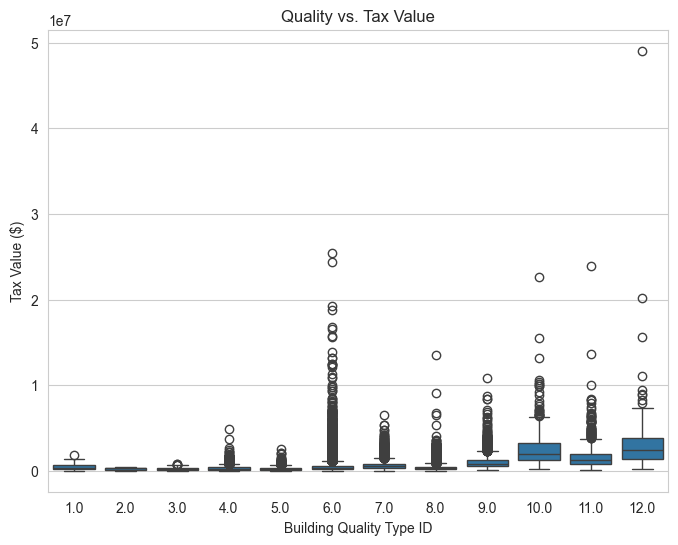

In [30]:
# Create a single figure and axis for one plot
plt.figure(figsize=(8, 6))

# Plot 3: Box plot of Quality vs. Value
sns.boxplot(
    x='buildingqualitytypeid',
    y='taxvaluedollarcnt',
    data=df_4b
)
plt.title('Quality vs. Tax Value')
plt.xlabel('Building Quality Type ID')
plt.ylabel('Tax Value ($)')

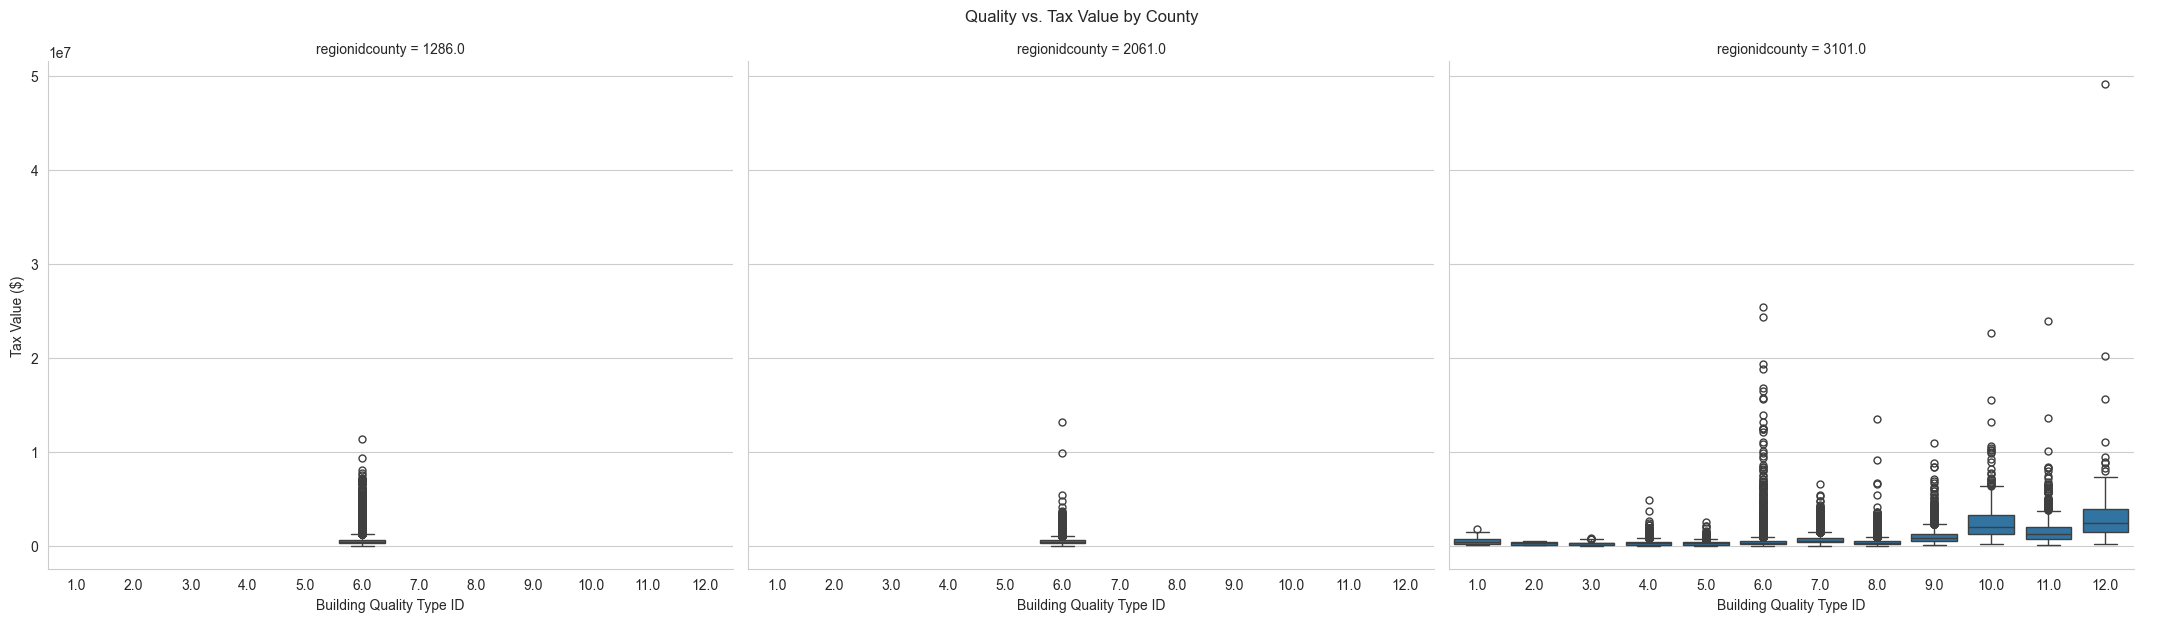

In [31]:
g = sns.catplot(
    data=df_4b,
    x='buildingqualitytypeid',
    y='taxvaluedollarcnt',
    col='regionidcounty', # Facet by county
    kind='box', # Specify the plot type
    height=6, # Set the height of each plot
    aspect=1.2 # Set the aspect ratio of each plot
)

# Add a main title
g.fig.suptitle('Quality vs. Tax Value by County', y=1.03)
# Set labels for all subplots
g.set_axis_labels("Building Quality Type ID", "Tax Value ($)")

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


Visual exploration of key feature pairs provided deeper, more nuanced insights that confirmed the statistical findings from Part 4.A. A scatter plot of `calculatedfinishedsquarefeet` versus `taxvaluedollarcnt` reaffirmed a strong, positive relationship, showing that property value clearly increases with area. A second scatter plot of `yearbuilt` against `taxvaluedollarcnt` revealed a complex, non-linear pattern, indicating that a simple linear interpretation of age would be insufficient.

The most significant insight came from a faceted box plot, which was used to analyze the relationship between `buildingqualitytypeid` and `taxvaluedollarcnt` across each `regionidcounty`. This visualization revealed a critical interaction effect: in the largest county (ID 3101.0), there was a clear, positive trend where higher quality grades corresponded to higher median property values. However, this pattern was not consistent across the other counties, where the data for many quality grades was sparse or non-existent. This demonstrates that the predictive power and nature of a feature can vary significantly by region, a key finding that suggests more complex modeling approaches may be necessary to capture these local effects.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr

# Copy the cleaned data
df_engineered = df_3d.copy()
print(f"Shape before feature engineering: {df_engineered.shape}")

# Set current year (2025)
current_year = 2025

# Transformation 1: Log Transform for skewed features (strong sqft only)
df_engineered['log_calculatedfinishedsquarefeet'] = np.log1p(df_engineered['calculatedfinishedsquarefeet'])

# Transformation 2: Ratio Features (domain-specific, no leakage)
# Bathrooms per bedroom ratio (handle zero bedrooms)
df_engineered['bath_bed_ratio'] = np.where(df_engineered['bedroomcnt'] > 0, 
                                           df_engineered['bathroomcnt'] / df_engineered['bedroomcnt'], 0)
# Sqft per lot size ratio (no target involved)
df_engineered['sqft_per_lot'] = df_engineered['calculatedfinishedsquarefeet'] / (df_engineered['lotsizesquarefeet'] + 1e-6)

# Transformation 3: Age Feature (home_age only, drop weak interaction)
df_engineered['home_age'] = current_year - df_engineered['yearbuilt']

# Transformation 4: Polynomial Feature (sqft squared for non-linearity)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_sqft = poly.fit_transform(df_engineered[['calculatedfinishedsquarefeet']])
df_engineered['calcsqft_squared'] = poly_sqft[:, 1]  # Add only the squared term

print(f"Shape after feature engineering: {df_engineered.shape}")

# One-Hot Encoding for categorical features (expand with your actual categoricals)
# Example columns: Add more like 'propertylandusetypeid', 'airconditioningtypeid', etc.
categorical_cols = ['regionidcounty', 'buildingqualitytypeid']  # Customize based on your dataset
df_engineered = pd.get_dummies(df_engineered, columns=categorical_cols, drop_first=True)

print(f"Shape after one-hot encoding: {df_engineered.shape}")
print("\n--- Evaluating New Features ---")

# Calculate correlations with target (including new features)
relevant_features = ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 
                     'bath_bed_ratio', 'sqft_per_lot', 'home_age', 'calcsqft_squared']
correlation_eval = df_engineered[relevant_features + ['taxvaluedollarcnt']].corr()['taxvaluedollarcnt'].sort_values(ascending=False)

print("\nCorrelation with 'taxvaluedollarcnt':")
print(correlation_eval)

# F-score evaluation function (optional, for full feature set)
def get_f_scores(X, y):
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    return dict(zip(X.columns, selector.scores_))

X_eval = df_engineered[relevant_features]
y = df_engineered['taxvaluedollarcnt']
f_scores = get_f_scores(X_eval, y)
print("\nF-scores for new features:")
print(f_scores)

Shape before feature engineering: (77380, 37)
Shape after feature engineering: (77380, 42)
Shape after one-hot encoding: (77380, 53)

--- Evaluating New Features ---

Correlation with 'taxvaluedollarcnt':
taxvaluedollarcnt                   1.000000
calculatedfinishedsquarefeet        0.578739
calcsqft_squared                    0.524916
log_calculatedfinishedsquarefeet    0.464886
bath_bed_ratio                      0.193002
sqft_per_lot                        0.166789
home_age                           -0.118962
Name: taxvaluedollarcnt, dtype: float64

F-scores for new features:
{'calculatedfinishedsquarefeet': 38969.170578731784, 'log_calculatedfinishedsquarefeet': 21333.377076459314, 'bath_bed_ratio': 2993.82332501766, 'sqft_per_lot': 2214.1308732884954, 'home_age': 1110.766658066599, 'calcsqft_squared': 29429.30236250004}


In [33]:
# Reuse df_engineered from previous cell
print(f"Starting shape: {df_engineered.shape}")

# Additional improvements: Convert home_age to binary (is_new_home for positive signal)
df_engineered['is_new_home'] = np.where(df_engineered['home_age'] < 20, 1, 0)  # 1 if built after 2005
# Drop raw home_age to reduce noise from negative correlation
df_engineered = df_engineered.drop('home_age', axis=1)

# Add total_rooms as a simple aggregation feature (Kaggle-inspired)
df_engineered['total_rooms'] = df_engineered['bedroomcnt'] + df_engineered['bathroomcnt']

print(f"Shape after additional transformations: {df_engineered.shape}")

# Re-evaluate with updated relevant features
relevant_features = ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 
                     'bath_bed_ratio', 'sqft_per_lot', 'is_new_home', 'calcsqft_squared', 'total_rooms']
correlation_eval = df_engineered[relevant_features + ['taxvaluedollarcnt']].corr()['taxvaluedollarcnt'].sort_values(ascending=False)

print("\nUpdated Correlation with 'taxvaluedollarcnt':")
print(correlation_eval)

# Re-run F-scores
X_eval = df_engineered[relevant_features]
y = df_engineered['taxvaluedollarcnt']
f_scores = get_f_scores(X_eval, y)  # Reuse the function from previous cell
print("\nUpdated F-scores for new features:")
print(f_scores)

Starting shape: (77380, 53)
Shape after additional transformations: (77380, 54)

Updated Correlation with 'taxvaluedollarcnt':
taxvaluedollarcnt                   1.000000
calculatedfinishedsquarefeet        0.578739
calcsqft_squared                    0.524916
log_calculatedfinishedsquarefeet    0.464886
total_rooms                         0.379071
bath_bed_ratio                      0.193002
sqft_per_lot                        0.166789
is_new_home                         0.113920
Name: taxvaluedollarcnt, dtype: float64

Updated F-scores for new features:
{'calculatedfinishedsquarefeet': 38969.170578731784, 'log_calculatedfinishedsquarefeet': 21333.377076459314, 'bath_bed_ratio': 2993.82332501766, 'sqft_per_lot': 2214.1308732884954, 'is_new_home': 1017.3945433054882, 'calcsqft_squared': 29429.30236250004, 'total_rooms': 12984.661171069361}


#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


We selected log transformation for skewed features like `calculatedfinishedsquarefeet` to normalize distributions and better expose exponential relationships with property values, as housing data often exhibits heavy tails with outliers. Ratio features such as `bath_bed_ratio` and `sqft_per_lot` were chosen based on domain knowledge to capture efficiency and density aspects not evident in individual counts or sizes, potentially highlighting luxury or utilization patterns. The polynomial squared term for sqft was added to emphasize non-linear effects, like accelerating value growth with larger areas, while converting `home_age` to a binary `is_new_home` indicator addressed the negative correlation of raw age by focusing on recent builds' premium. Finally, `total_rooms` aggregated bedroom and bathroom counts for a simple holistic measure of property scale. Observations from correlations and F-scores revealed that sqft-related transformations remained dominant (correlations 0.58–0.46, F-scores 39k–21k), confirming their core predictive power, with `total_rooms` adding moderate strength (0.38/13k) and the binary age improving signal positivity (0.11/1k) over the raw version. Weaker features like lot-related ratios (0.17/2k) provided supplementary insights without dominating, overall enhancing the dataset's relevance for machine learning while reducing noise from underperforming elements.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

